# Imports

In [38]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from datetime import date
import matplotlib.pyplot as plt

# Load Precipitation Data

In [2]:
filepath = 'data/ky_prec_with_gps.csv'

cols = ['STATION', 'DATE', 'PRCP', 'LATITUDE', 'LONGITUDE']

dtypes = {
    'STATION': 'category',
    'DATE': 'string',
    'PRCP': 'float32',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
}

weather_df = pd.read_csv(filepath, dtype=dtypes, usecols=cols)

weather_df['DATE'] = pd.to_datetime(pd.Series(weather_df['DATE']), format='%Y-%m-%d', errors='coerce').dt.date
weather_df['PRCP'] = weather_df['PRCP'].fillna(0)
weather_df['PRCP'] = weather_df.PRCP.apply(lambda x: x * 100).apply(np.int32)

display(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955383 entries, 0 to 1955382
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   STATION    category
 1   LATITUDE   float32 
 2   LONGITUDE  float32 
 3   DATE       object  
 4   PRCP       int32   
dtypes: category(1), float32(2), int32(1), object(1)
memory usage: 41.1+ MB


None

In [3]:
display(weather_df.head(1))

,STATION,LATITUDE,LONGITUDE,DATE,PRCP
0,US1KYMS0002,38.532425,-83.754707,2009-04-17,0


# Load FEMA Project Data

In [22]:
filepath2 = 'data/PublicAssistanceFundedProjectsDetails.csv'

cols=[
    'disasterNumber',
    'stateCode',
    'countyCode',
    'county',
    'projectSize',
    'dcc',             # Determines if damage is Roads & Bridges
    'projectAmount'
]


dtypes={
    'disasterNumber': 'category',
    'county': 'category',
    'countyCode': 'category',
    'projectSize': 'category',
    'dcc': 'category',
    'stateCode': 'category',
    'projectAmount': 'float32'
}

df2 = pd.read_csv(filepath2, usecols=cols, dtype=dtypes)

filtered_df = df2.loc[(df2.stateCode == 'KY') & (df2.dcc == 'C')]

final_data = filtered_df.drop(labels=['stateCode', 'dcc',], axis=1)

display(final_data.info())
display(final_data.head(5))

# Get unique counties in sorted order
unique_counties = final_data['county'].dropna().cat.remove_unused_categories()
unique_counties = pd.DataFrame(sorted(unique_counties.unique()), columns=['Unique Counties'])
print(unique_counties.to_string(index=False))



<class 'pandas.core.frame.DataFrame'>
Index: 15139 entries, 59 to 807119
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   disasterNumber  15139 non-null  category
 1   projectSize     15139 non-null  category
 2   county          15137 non-null  category
 3   countyCode      15139 non-null  category
 4   projectAmount   15139 non-null  float32 
dtypes: category(4), float32(1)
memory usage: 456.4 KB


None

,disasterNumber,projectSize,county,countyCode,projectAmount
59,4663,Small,Letcher County,133,535403.750000
73,4711,Small,Lee County,129,102442.460938
109,4663,Small,Letcher County,133,15449.780273
112,4663,Small,Letcher County,133,6900.930176
121,4711,Small,Breathitt County,25,89828.742188


    Unique Counties
       Adair County
       Allen County
           Anderson
    Anderson County
            Ballard
     Ballard County
      Barren County
               Bath
        Bath County
               Bell
        Bell County
              Boone
     Bourbon County
               Boyd
        Boyd County
       Boyle County
            Bracken
     Bracken County
          Breathitt
   Breathitt County
       Breckinridge
Breckinridge County
     Bullitt County
      Butler County
           Caldwell
    Caldwell County
           Calloway
    Calloway County
           Campbell
    Campbell County
           Carlisle
    Carlisle County
            Carroll
     Carroll County
             Carter
      Carter County
              Casey
       Casey County
          Christian
   Christian County
       Clark County
               Clay
        Clay County
     Clinton County
         Crittenden
  Crittenden County
  Cumberland County
            Daviess
     Daviess County


# Geopandas

In [7]:
county_shp_filename = 'zip:data/cb_2018_us_county_500k.zip'
gdf_counties = gpd.read_file(county_shp_filename)

In [ ]:
stations_list = 'data/ghcnd-stations.csv' #incorrect file

cols=[
    'STATION',
    'LATITUDE',
    'LONGITUDE',
]

dtypes = {
    'STATION': 'category',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
}

stations_df = pd.read_csv(stations_list, dtype=dtypes, usecols=cols)
display(stations_df.head(5))

,STATION,LATITUDE,LONGITUDE
0,ACW00011604,17.116699,-61.783298
1,ACW00011647,17.133301,-61.783298
2,AE000041196,25.333000,55.516998
3,AEM00041194,25.254999,55.363998
4,AEM00041217,24.433001,54.651001


In [10]:
gps = (38.532426, -83.754705)
point = Point(gps[1], gps[0])

county = gdf_counties[gdf_counties.geometry.contains(point)]
display(county)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3125,21,161,00516924,0500000US21161,21161,Mason,06,621924068,16281864,"POLYGON ((-83.9916 38.5937, -83.96257 38.65396..."


In [11]:
# def get_gps_from_station(name):
#     station = stations_df[stations_df['STATION'] == name]
#     return (station['LATITUDE'], station['LONGITUDE'])

def get_county_from_gps(lat, long):
    point = Point(long, lat)
    county = gdf_counties[gdf_counties.geometry.contains(point)]
    return str(county['NAME'])

# Shorthand for the 2 above functions
def get_county_from_station(name):
    gps = get_gps_from_station(name)
    county = get_county_from_gps(gps[0], gps[1])
    return county

In [31]:
# Parital Test of grabbing county for stations
# part_weather_df = weather_df[weather_df['DATE'] >= date(2025,3,1)]
# counties = part_weather_df.apply(lambda x: get_county_from_gps(x['LATITUDE'], x['LONGITUDE']), axis=1)
# display(counties)

# Full
# weather_df['COUNTY'] = weather_df.apply(lambda x: get_county_from_gps(x['LATITUDE'], x['LONGITUDE']), axis=1)
# display(weather_df.info())

# Can probably be improved by doing only getting counties for unique stations then

df_unique_stations = weather_df[['STATION', 'LATITUDE', 'LONGITUDE']].drop_duplicates()

df_unique_stations['COUNTY'] = df_unique_stations.apply(lambda x: get_county_from_gps(x['LATITUDE'], x['LONGITUDE']), axis=1).astype('category')

weather_df_with_county = weather_df.merge(
    df_unique_stations[['STATION', 'COUNTY']],
    on='STATION',
    how='left'
)

display(weather_df_with_county.info())
display(weather_df_with_county.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955383 entries, 0 to 1955382
Data columns (total 6 columns):
 #   Column     Dtype   
---  ------     -----   
 0   STATION    category
 1   LATITUDE   float32 
 2   LONGITUDE  float32 
 3   DATE       object  
 4   PRCP       int32   
 5   COUNTY     category
dtypes: category(2), float32(2), int32(1), object(1)
memory usage: 44.8+ MB


None

,STATION,LATITUDE,LONGITUDE,DATE,PRCP,COUNTY
0,US1KYMS0002,38.532425,-83.754707,2009-04-17,0,"3125 Mason\nName: NAME, dtype: object"
1,US1KYMS0002,38.532425,-83.754707,2009-04-18,0,"3125 Mason\nName: NAME, dtype: object"
2,US1KYMS0002,38.532425,-83.754707,2009-04-19,30,"3125 Mason\nName: NAME, dtype: object"
3,US1KYMS0002,38.532425,-83.754707,2009-04-20,2029,"3125 Mason\nName: NAME, dtype: object"
4,US1KYMS0002,38.532425,-83.754707,2009-04-21,329,"3125 Mason\nName: NAME, dtype: object"


In [44]:
# Step 1: Load the county shapefile
county_gdf = gpd.read_file("data/cb_2024_us_county_500k/cb_2024_us_county_500k.shp")

# Step 1: Load the county shapefile
county_gdf = gpd.read_file("data/cb_2024_us_county_500k/cb_2024_us_county_500k.shp")

# Step 2: Filter for Kentucky using the 'STATEFP' column (FIPS code for KY is '21')
kentucky_counties = county_gdf[county_gdf['STATEFP'] == '21']

# Step 3: Extract the relevant columns (county name, county code, state, and geometry)
result = kentucky_counties[['NAME', 'COUNTYFP', 'STATEFP', 'geometry']]

# Step 4: Rename the columns for better clarity
result = result.rename(columns={
    'NAME': 'county_name',
    'COUNTYFP': 'county_code',
    'STATEFP': 'state_code',
    'geometry': 'polygon'
})

bounds = kentucky_counties.bounds

# Find the extreme values
min_lat = bounds['miny'].min()
max_lat = bounds['maxy'].max()
min_lon = bounds['minx'].min()
max_lon = bounds['maxx'].max()

print(f"Latitude range: {min_lat} to {max_lat}")
print(f"Longitude range: {min_lon} to {max_lon}")

# Step 5: Display the filtered data
print(result.head(5))

Latitude range: 36.497129 to 39.147458
Longitude range: -89.571509 to -81.964971
    county_name county_code state_code  \
44      Whitley         235         21   
50      Letcher         133         21   
181       Larue         123         21   
182     Johnson         115         21   
183     Jackson         109         21   

                                               polygon  
44   POLYGON ((-84.35585 36.81211, -84.35527 36.813...  
50   POLYGON ((-83.15345 36.95947, -83.15008 36.962...  
181  POLYGON ((-85.89446 37.47231, -85.89334 37.472...  
182  POLYGON ((-83.00349 37.86145, -83.00248 37.862...  
183  POLYGON ((-84.20429 37.50488, -84.20478 37.507...  


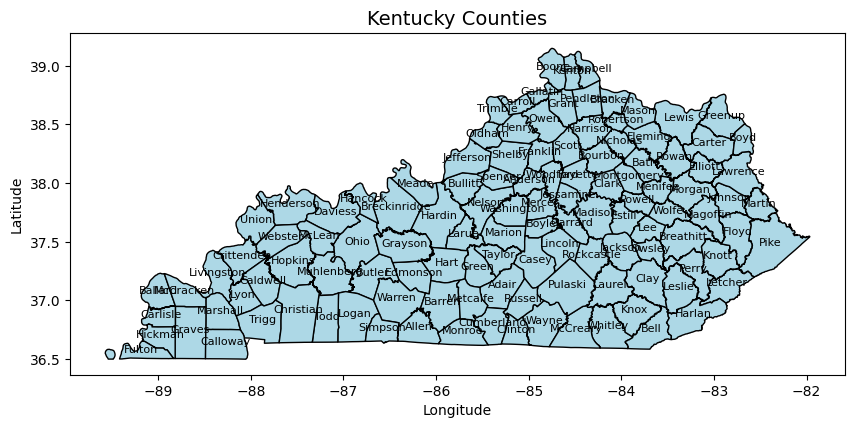

In [39]:
# Step 3: Plot the polygons (county boundaries) for Kentucky
fig, ax = plt.subplots(figsize=(10, 10))
kentucky_counties.plot(ax=ax, color='lightblue', edgecolor='black')

# Step 4: Add labels for county names (optional)
for idx, row in kentucky_counties.iterrows():
    ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['NAME'], fontsize=8, ha='center')

# Step 5: Set title and labels
ax.set_title("Kentucky Counties", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

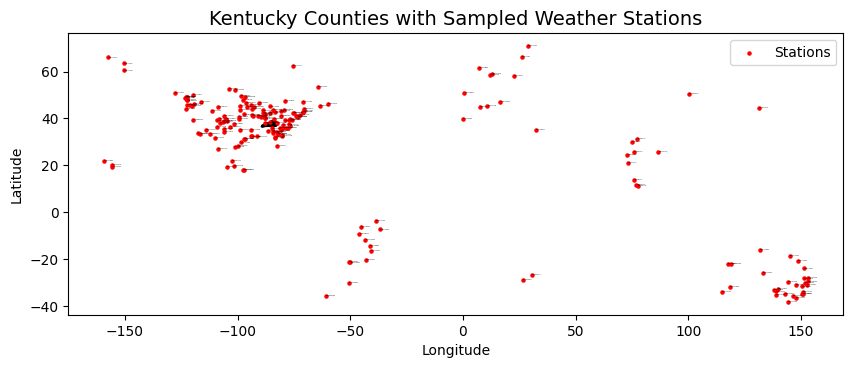

In [42]:
# Step 3: Load station data
stations_list = 'data/ghcnd-stations.csv'
cols = ['STATION', 'LATITUDE', 'LONGITUDE']
dtypes = {'STATION': 'category', 'LATITUDE': 'float32', 'LONGITUDE': 'float32'}
stations_df = pd.read_csv(stations_list, dtype=dtypes, usecols=cols)

# Step 4: Randomly sample 200 stations
stations_df_sampled = stations_df.sample(n=200, random_state=42)

# Step 5: Convert the sampled station data to GeoDataFrame for spatial plotting
stations_gdf = gpd.GeoDataFrame(
    stations_df_sampled,
    geometry=[Point(xy) for xy in zip(stations_df_sampled['LONGITUDE'], stations_df_sampled['LATITUDE'])],
    crs="EPSG:4326"
)

# Step 6: Plot the counties and stations
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Kentucky counties
kentucky_counties.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot the sampled stations as red points
stations_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Stations')

# Add labels for each station (optional)
for idx, row in stations_gdf.iterrows():
    ax.text(row['geometry'].x, row['geometry'].y, row['STATION'], fontsize=1, ha='left')

# Step 7: Set title and labels
ax.set_title("Kentucky Counties with Sampled Weather Stations", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot with the legend
ax.legend()
plt.show()

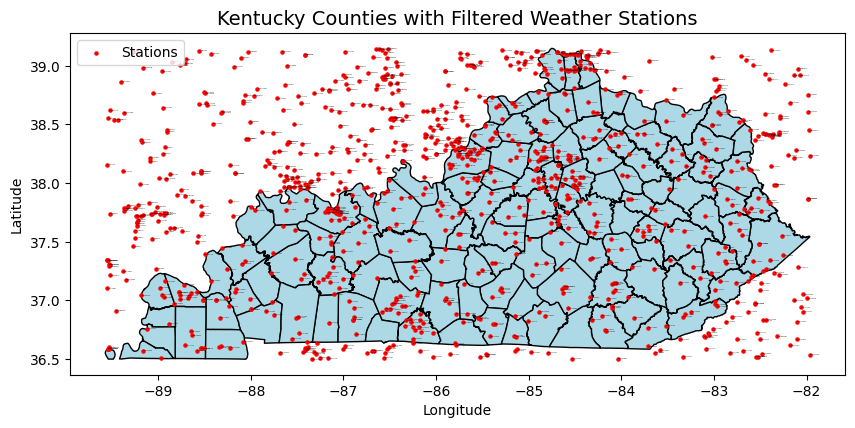

In [52]:
# Kentucky bounds
MIN_LAT, MAX_LAT = 36.497129, 39.147458
MIN_LON, MAX_LON = -89.571509, -81.964971

# Step 1: Load and filter the weather station data
stations_list = 'data/ghcnd-stations.csv'
cols = ['STATION', 'LATITUDE', 'LONGITUDE']
dtypes = {'STATION': 'category', 'LATITUDE': 'float32', 'LONGITUDE': 'float32'}
stations_df = pd.read_csv(stations_list, dtype=dtypes, usecols=cols)

# Step 2: Filter by latitude and longitude bounds
stations_df_filtered = stations_df[
    (stations_df['LATITUDE'] >= MIN_LAT) &
    (stations_df['LATITUDE'] <= MAX_LAT) &
    (stations_df['LONGITUDE'] >= MIN_LON) &
    (stations_df['LONGITUDE'] <= MAX_LON)
]

# Step 3: Randomly sample 200 stations within bounds
stations_df_sampled = stations_df_filtered.sample(n=1000, random_state=42)

# Step 4: Convert to GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df_sampled,
    geometry=[Point(xy) for xy in zip(stations_df_sampled['LONGITUDE'], stations_df_sampled['LATITUDE'])],
    crs="EPSG:4326"
)

# Step 5: Load and filter counties for Kentucky
county_gdf = gpd.read_file("data/cb_2024_us_county_500k/cb_2024_us_county_500k.shp")
kentucky_counties = county_gdf[county_gdf['STATEFP'] == '21']

# Step 6: Plot counties and filtered stations
fig, ax = plt.subplots(figsize=(10, 10))
kentucky_counties.plot(ax=ax, color='lightblue', edgecolor='black')
stations_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Stations')

# Optional: Label station names
for idx, row in stations_gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row.STATION, fontsize=1, ha='left')

ax.set_title("Kentucky Counties with Filtered Weather Stations", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [53]:
# Define Kentucky bounding box
MIN_LAT, MAX_LAT = 36.497129, 39.147458
MIN_LON, MAX_LON = -89.571509, -81.964971

# Step 1: Load and filter the weather station data
stations_list = 'data/ghcnd-stations.csv'
cols = ['STATION', 'LATITUDE', 'LONGITUDE']
dtypes = {'STATION': 'category', 'LATITUDE': 'float32', 'LONGITUDE': 'float32'}
stations_df = pd.read_csv(stations_list, dtype=dtypes, usecols=cols)

# Step 2: Filter by Kentucky bounding box
stations_df_filtered = stations_df[
    (stations_df['LATITUDE'] >= MIN_LAT) &
    (stations_df['LATITUDE'] <= MAX_LAT) &
    (stations_df['LONGITUDE'] >= MIN_LON) &
    (stations_df['LONGITUDE'] <= MAX_LON)
]

# Step 3: Sample 1000 stations
stations_df_sampled = stations_df_filtered.sample(n=1000, random_state=42)

# Step 4: Convert to GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df_sampled,
    geometry=[Point(xy) for xy in zip(stations_df_sampled['LONGITUDE'], stations_df_sampled['LATITUDE'])],
    crs="EPSG:4326"
)

# Step 5: Load Kentucky counties shapefile
county_gdf = gpd.read_file("data/cb_2024_us_county_500k/cb_2024_us_county_500k.shp")
kentucky_counties = county_gdf[county_gdf['STATEFP'] == '21']

# Step 6: Spatial join to find which station is in which county
joined = gpd.sjoin(stations_gdf, kentucky_counties, how="inner", predicate='within')

# Step 7: Build final table with desired columns
final_table = joined[['NAME', 'COUNTYFP', 'STATION']].rename(columns={
    'NAME': 'county_name',
    'COUNTYFP': 'county_code',
    'STATION': 'weather_station'
}).sort_values(by=['county_name', 'weather_station'])

# Display the first few rows of the table
print(final_table.head(10))

       county_name county_code weather_station
71273        Adair         001     US1KYAD0001
71274        Adair         001     US1KYAD0003
106324       Adair         001     USC00151722
106325       Adair         001     USC00151725
71275        Allen         003     US1KYAL0001
71276        Allen         003     US1KYAL0003
71277        Allen         003     US1KYAL0004
71279        Allen         003     US1KYAL0006
71280        Allen         003     US1KYAL0007
71281        Allen         003     US1KYAL0011


C:\Users\efaris\AppData\Local\Temp\ipykernel_2700\2090168400.py:34: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  joined = gpd.sjoin(stations_gdf, kentucky_counties, how="inner", predicate='within')
